<a href="https://colab.research.google.com/github/FGalvao77/Implementando-Redes-Generativas-Adversarias-GAN-do-ZERO-PyTorch-Deep-Learning/blob/main/01_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implementando Redes Generativas Adversárias (GAN) do ZERO | PyTorch | Deep Learning**

---



In [1]:
# importando as bibliotecas e as funções necessárias
import torch
import matplotlib.pyplot as plt
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn,  optim
from IPython import display

In [2]:
# definindo as configurações para uso das imagens
imgsize = 28        # resolução da imagem
batch_size = 128    # quantidade do agupamentos das imagens

In [3]:
# criando diretórios no google drive para salvar o conjunto de dados das imagens
DATA_DIR = '/content/drive/MyDrive/PrimeiraGAN'     # pasta para salvar o conjunto de dados das imagens
IMG_DIR = os.path.join(DATA_DIR, 'results')         # para salvar as imagens geradas pelo modelo

In [4]:
# instanciando o transformador das imagens
fashion_transform = transforms.Compose(
    [transforms.ToTensor(), # convertendo para tensor
     transforms.Normalize(
         (0.5), (0.5))  # normalizando as imagens - com média de 0.5 e desvio padrão de 0.5
    ]
)

# instanciando o conjunto de dados na variável "fashion_data"
# passando como argumentos o diretório onde foi realizado o download das imagens,
# o transformador e download recebe True
fashion_data = datasets.FashionMNIST(DATA_DIR, 
                                     transform=fashion_transform,
                                     download=True)

# instanciando o objeto que irá iterar as imagens
# passando como argumentos a variável "fashion_data"
# o tamanho dos agrupamentos
# e a função "shuffle=True" para embaralhar as imagens
dataloader = DataLoader(fashion_data, 
                        batch_size=batch_size, 
                        shuffle=True)

In [5]:
# instanciando a primeira imagem e seu rótulo para visualizarmos
img, label = fashion_data[0]

In [6]:
# visualizando a imagem
img

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1

> Veja que a imagem em questão é um tensor!

In [7]:
# visualizando o rótulo da imagem
label

9

In [8]:
# visualizando a quantidade de imagens
len(fashion_data)

60000

In [9]:
# visualizando o tipo do objeto
type(fashion_data)

torchvision.datasets.mnist.FashionMNIST

In [10]:
# criando uma função para auxiliar na visualização das imagens
def lookat_dataset(dataset, pilimg=False):
    figure = plt.figure(figsize=[16, 4])    # tamanho das imagens
    rows, cols = 2, 8   # 2 linhas por 8 colunas, toatalizando 16 imagens

    # realizando um laço de repetição de 1 até 17
    for i in range(1, 17):
        sample_idx = torch.randint(len(dataset),    # visualizando as imagens aleatórias
                                   size=(1,)).item()

        img, label = dataset[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.axis('off')

        if pilimg:
            plt.imshow(img)
        else:
            img = (img.squeeze() * 0.5) + 0.5

            if len(img.shape) == 2:
                plt.imshow(img, cmap='gray')    # imagens no tons de cinza
            else:
                plt.imshow(img.permute(1, 2, 0))

    plt.show();

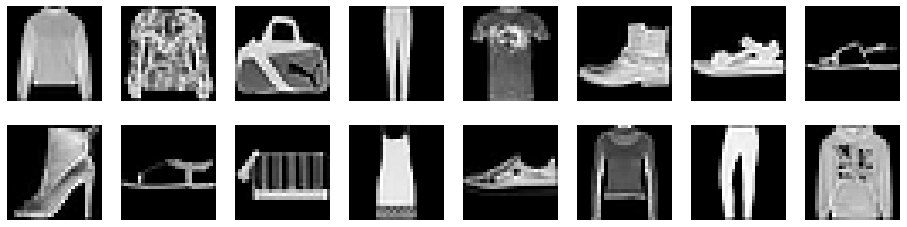

In [11]:
# visualizando as imagens
lookat_dataset(fashion_data)

In [12]:
# definindo a arquitetura da rede neural

# instanciando o gerador
class Generator(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()

        # definindo as camadas da rede neural
        self.layers = nn.Sequential(

            # entrada e saída da camada
            nn.Linear(n_input, 256),
            nn.LeakyReLU(),     # função de ativação

            nn.Linear(256, 512),
            nn.LeakyReLU(),

            nn.Linear(512, 1024),
            nn.LeakyReLU(),

            nn.Linear(1024, n_output),
            nn.Tanh()
        )

    def forward(self, z):
        return self.layers(z)

# instanciando o discriminador
class Discriminator(nn.Module):
    def __init__(self, n_input):
        super().__init__()
        n_output = 1

        # definindo as camadas da rede neural
        self.layers = nn.Sequential(

            # entrada e saída da camada
            nn.Linear(n_input, 1024),
            nn.LeakyReLU(0.2),      # função de ativação
       
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
        
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
     
            nn.Linear(256, n_output),
            nn.Sigmoid()
        )
            
    def forward(self, x):
        return self.layers(x)

In [13]:
# instanciando o ambiente que está rodando a rede neural
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Rodando na {device}')

Rodando na cpu


In [14]:
# instaciando a dimensão do ruído
noise_dim = 100

# instanciando o gerador com a dimensão do ruído e o tamanho das imagens
generator = Generator(noise_dim, 
                      imgsize * imgsize).to(device)
                      
discriminator = Discriminator(imgsize * imgsize).to(device)

In [15]:
# função para transformar as imagens em vetores
def images_to_vectors(images):
    return images.view(images.size(0), 
                       imgsize * imgsize)

# função para transformar os vetores para imagens  
def vectors_to_images(vectors, nc=1):
    return vectors.view(vectors.size(0), 
                        nc, imgsize, imgsize)

# função para gerar ruídos
def noise(size, dim=noise_dim, device=device):
    return torch.randn(size, 
                       dim).to(device)

# função para visualizar as imagens
def log_images(test_images, savepath=None):
    figure = plt.figure(figsize=[8, 8])
    figure.subplots_adjust(wspace=0.08,
                           hspace=0.01)
    
    rows, cols = len(test_images) // 4, 4

    for i, img in enumerate(test_images):
        figure.add_subplot(rows, cols, i + 1)
        plt.axis('off')
        plt.imshow(img.squeeze(), 
                   cmap='gray')

    if savepath is not None:   
        figure.savefig(savepath)

    plt.show();

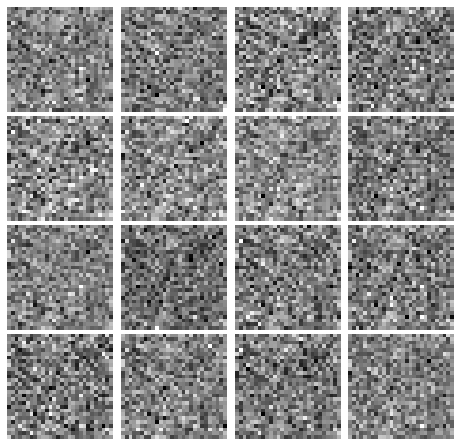

In [16]:
# tamanho das amostras
num_test_samples = 16

# definindo a semente do modelo
torch.manual_seed(7777)

# instanciando o ruído do teste
test_noise = noise(num_test_samples,
                   noise_dim)

# salvando as imagens na pasta
imagepath = os.path.join(IMG_DIR, f'{0}.jpg')

# realizando a visualização da imagem
log_images(
    vectors_to_images(
        generator(test_noise)).cpu().detach().numpy(), 
        imagepath
)

In [17]:
# função para rótulo dos dados reais
def real_data_target(size, device=device):
    return torch.ones(size, 1).to(device)

# função para rótulo dos dados falsos
def fake_data_target(size, device=device):
    return torch.zeros(size, 1).to(device)

In [18]:
# taxa de aprendizagem
lr = 0.0002

# otimizador do gerador
g_optimizer = optim.Adam(generator.parameters(), 
                         lr = lr)

# otimizador do discriminador
d_optimizer = optim.Adam(discriminator.parameters(), 
                         lr = lr)

# função para cálculo do erro
loss = nn.BCELoss()

In [19]:
# função para treinar o gerador
def train_generator(optimizer, fake_data):
    optimizer.zero_grad()

    pred = discriminator(fake_data)

    error = loss(
        pred,
        real_data_target(pred.size(0)))
    error.backward()
    
    optimizer.step()

    return error

# função para treinar o gerador
def train_discriminator(optimizer, real_data, fake_data):
    optimizer.zero_grad()

    pred_real = discriminator(real_data)
    error_real = loss(pred_real, 
                      real_data_target(real_data.size(0)))
    
    error_real.backward()

    pred_fake = discriminator(fake_data)
    error_fake = loss(pred_fake, 
                      fake_data_target(fake_data.size(0)))
    error_fake.backward()

    optimizer.step()

    return error_real + error_fake, pred_real, pred_fake

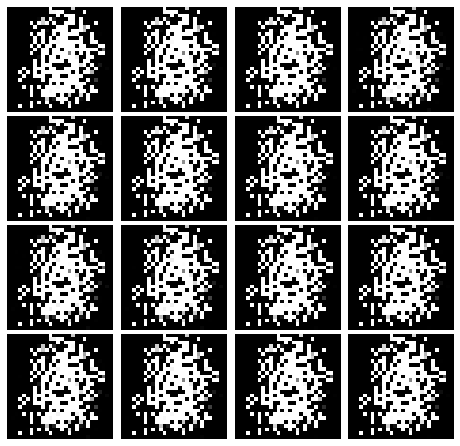

Epoch: 0 / 100 Losses: 
Discriminator: 0.0032 | Generator 6.7901
D(x): 0.9986 | D(G(z)): 0.0018


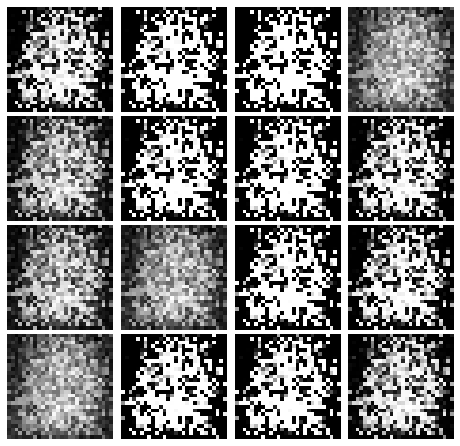

Epoch: 1 / 100 Losses: 
Discriminator: 0.0135 | Generator 9.2128
D(x): 0.9999 | D(G(z)): 0.0132


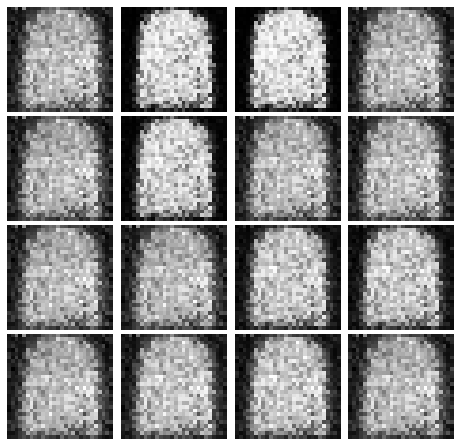

Epoch: 2 / 100 Losses: 
Discriminator: 0.0444 | Generator 8.1293
D(x): 0.9920 | D(G(z)): 0.0281


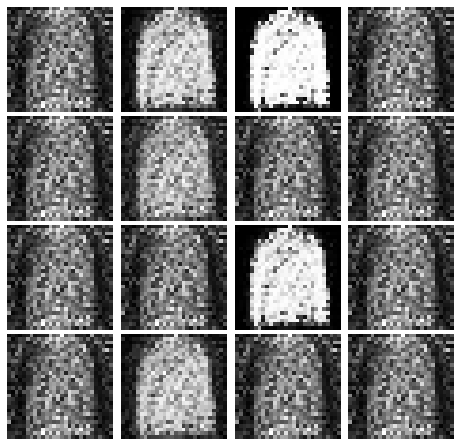

Epoch: 3 / 100 Losses: 
Discriminator: 0.1565 | Generator 7.7085
D(x): 0.9979 | D(G(z)): 0.1368


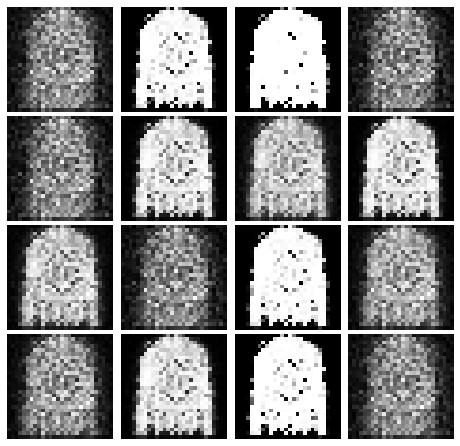

Epoch: 4 / 100 Losses: 
Discriminator: 0.1426 | Generator 7.0660
D(x): 0.9540 | D(G(z)): 0.0378


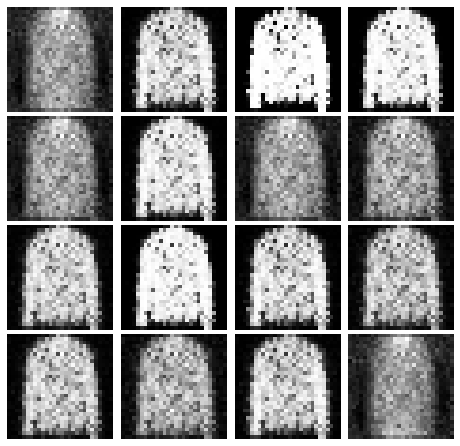

Epoch: 5 / 100 Losses: 
Discriminator: 0.1065 | Generator 4.6517
D(x): 0.9665 | D(G(z)): 0.0340


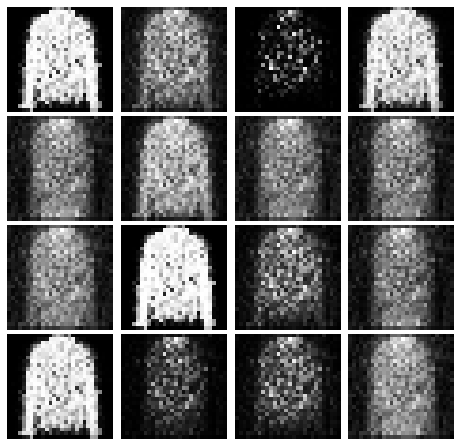

Epoch: 6 / 100 Losses: 
Discriminator: 0.0952 | Generator 5.1799
D(x): 0.9924 | D(G(z)): 0.0798


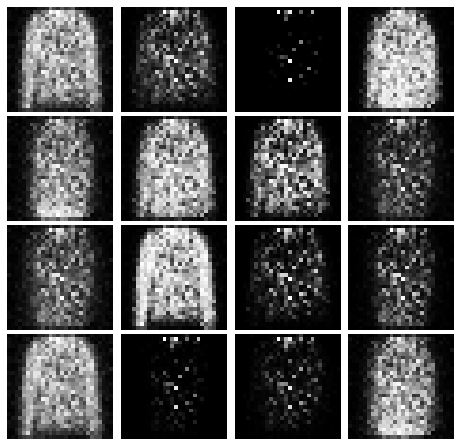

Epoch: 7 / 100 Losses: 
Discriminator: 0.0723 | Generator 6.6317
D(x): 0.9771 | D(G(z)): 0.0254


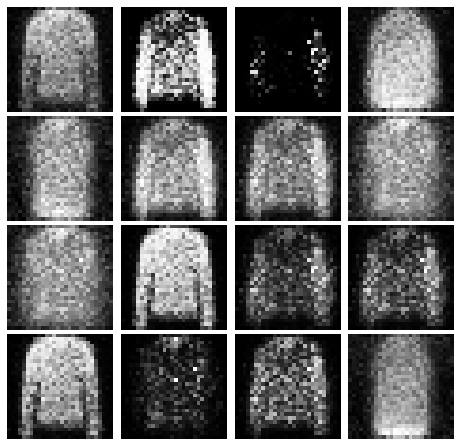

Epoch: 8 / 100 Losses: 
Discriminator: 0.4166 | Generator 4.0010
D(x): 0.8939 | D(G(z)): 0.0712


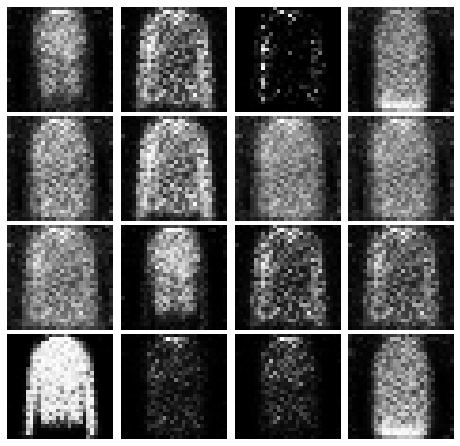

Epoch: 9 / 100 Losses: 
Discriminator: 0.1431 | Generator 4.7242
D(x): 0.9772 | D(G(z)): 0.0783


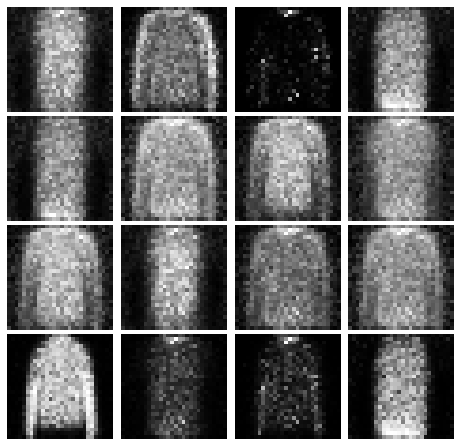

Epoch: 10 / 100 Losses: 
Discriminator: 0.2647 | Generator 3.5092
D(x): 0.9103 | D(G(z)): 0.0446


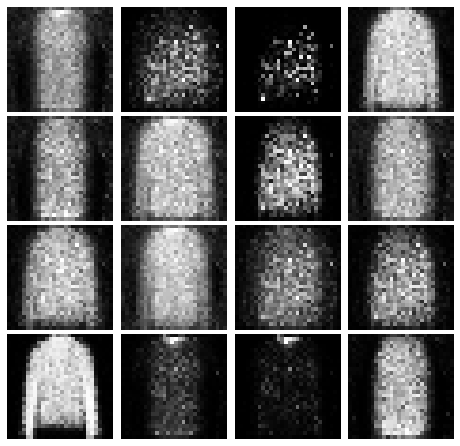

Epoch: 11 / 100 Losses: 
Discriminator: 0.2846 | Generator 3.7239
D(x): 0.9455 | D(G(z)): 0.0874


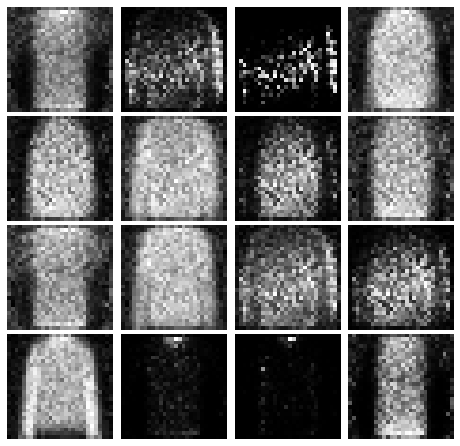

Epoch: 12 / 100 Losses: 
Discriminator: 0.1849 | Generator 3.6602
D(x): 0.9544 | D(G(z)): 0.0637


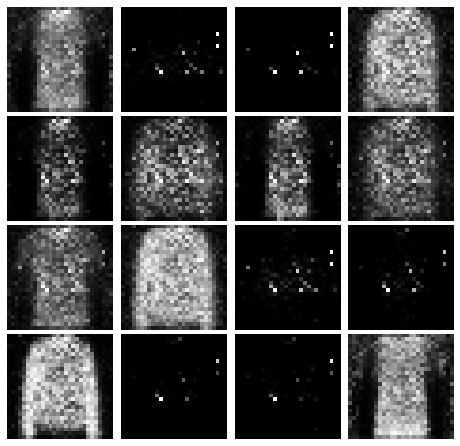

Epoch: 13 / 100 Losses: 
Discriminator: 0.1704 | Generator 4.8372
D(x): 0.9354 | D(G(z)): 0.0224


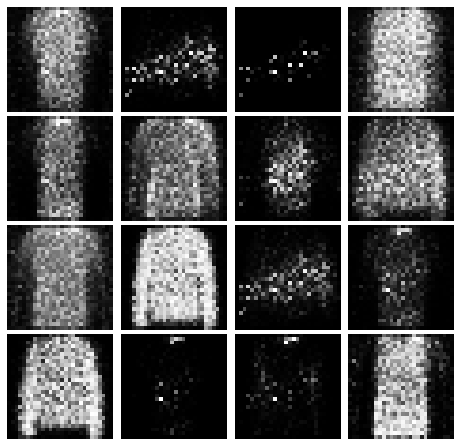

Epoch: 14 / 100 Losses: 
Discriminator: 0.2249 | Generator 5.7616
D(x): 0.9196 | D(G(z)): 0.0219


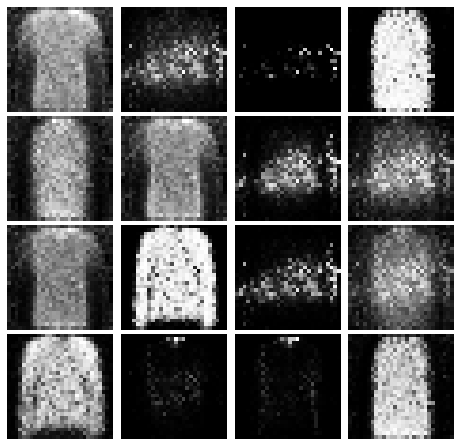

Epoch: 15 / 100 Losses: 
Discriminator: 0.5247 | Generator 4.3820
D(x): 0.8161 | D(G(z)): 0.0941


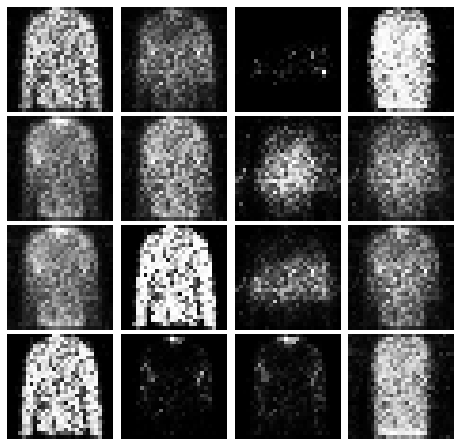

Epoch: 16 / 100 Losses: 
Discriminator: 0.3823 | Generator 3.1494
D(x): 0.9036 | D(G(z)): 0.1353


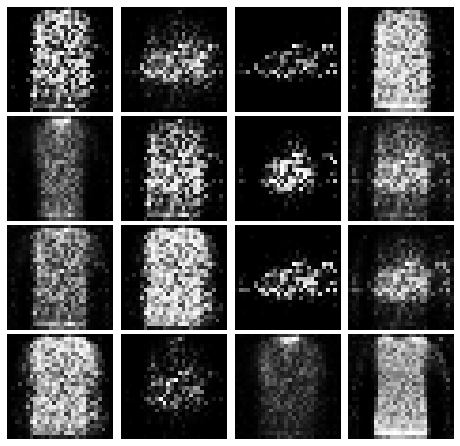

Epoch: 17 / 100 Losses: 
Discriminator: 0.4459 | Generator 2.8846
D(x): 0.8633 | D(G(z)): 0.1506


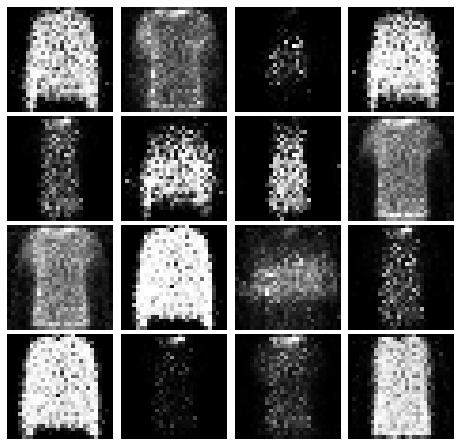

Epoch: 18 / 100 Losses: 
Discriminator: 0.4567 | Generator 5.9878
D(x): 0.9141 | D(G(z)): 0.1138


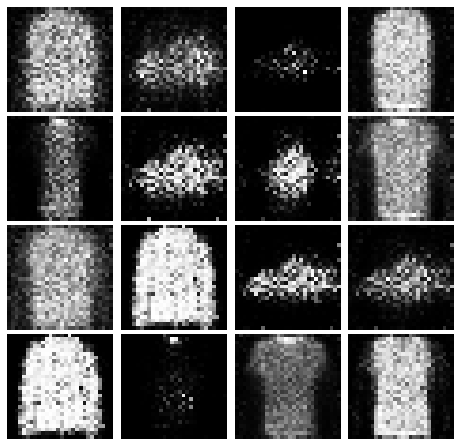

Epoch: 19 / 100 Losses: 
Discriminator: 0.3467 | Generator 4.5533
D(x): 0.8812 | D(G(z)): 0.0267


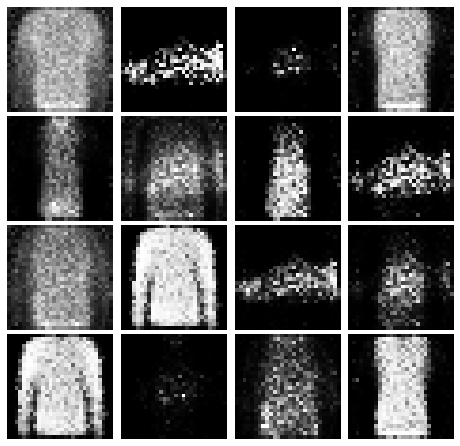

Epoch: 20 / 100 Losses: 
Discriminator: 0.4769 | Generator 2.8448
D(x): 0.8277 | D(G(z)): 0.1040


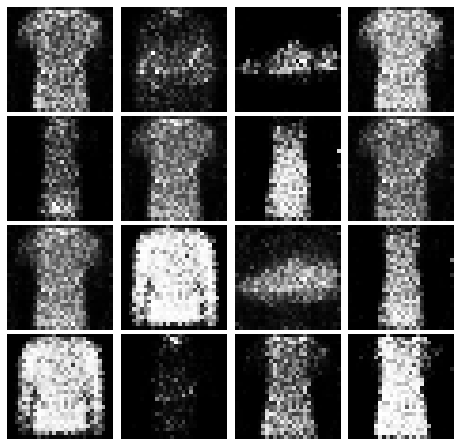

Epoch: 21 / 100 Losses: 
Discriminator: 0.4653 | Generator 2.4420
D(x): 0.8369 | D(G(z)): 0.0945


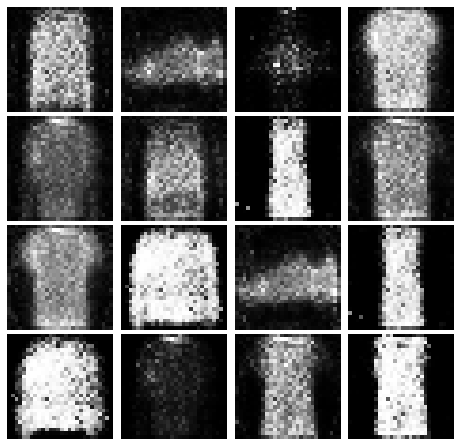

Epoch: 22 / 100 Losses: 
Discriminator: 0.3902 | Generator 2.2817
D(x): 0.9166 | D(G(z)): 0.1822


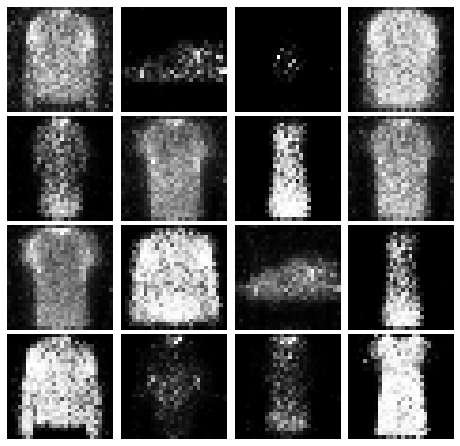

Epoch: 23 / 100 Losses: 
Discriminator: 0.3216 | Generator 3.9593
D(x): 0.8804 | D(G(z)): 0.0883


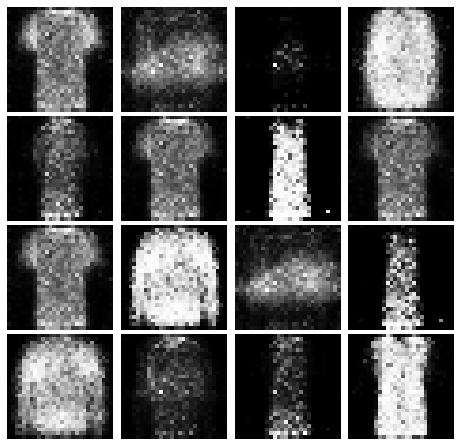

Epoch: 24 / 100 Losses: 
Discriminator: 0.2692 | Generator 3.9320
D(x): 0.9489 | D(G(z)): 0.1610


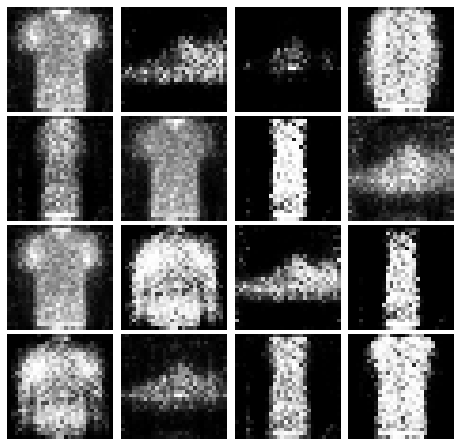

Epoch: 25 / 100 Losses: 
Discriminator: 0.4048 | Generator 2.5976
D(x): 0.8796 | D(G(z)): 0.1570


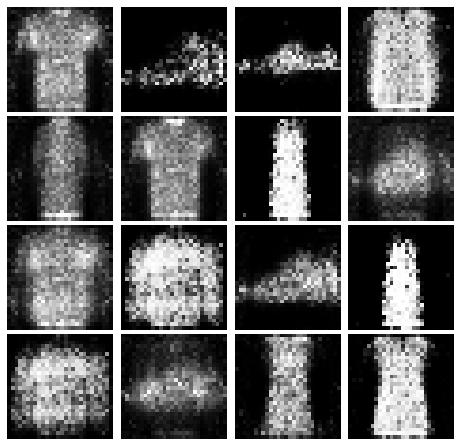

Epoch: 26 / 100 Losses: 
Discriminator: 0.3755 | Generator 4.2044
D(x): 0.8738 | D(G(z)): 0.1064


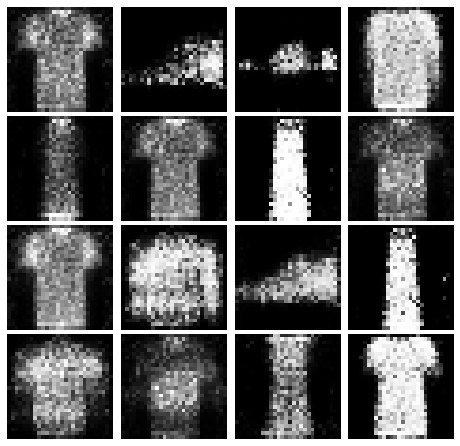

Epoch: 27 / 100 Losses: 
Discriminator: 0.7304 | Generator 2.5236
D(x): 0.7350 | D(G(z)): 0.1325


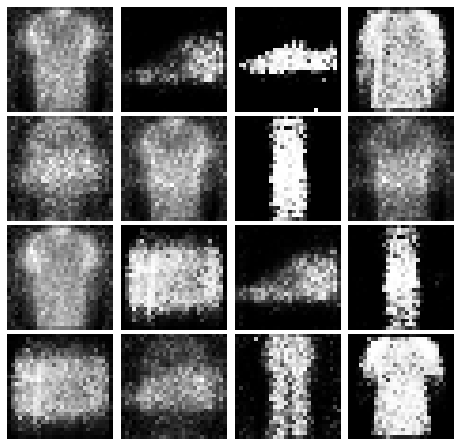

Epoch: 28 / 100 Losses: 
Discriminator: 0.3046 | Generator 4.2461
D(x): 0.8878 | D(G(z)): 0.0560


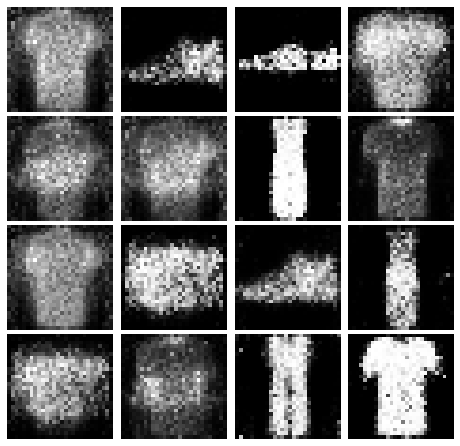

Epoch: 29 / 100 Losses: 
Discriminator: 0.3048 | Generator 3.3684
D(x): 0.9088 | D(G(z)): 0.1244


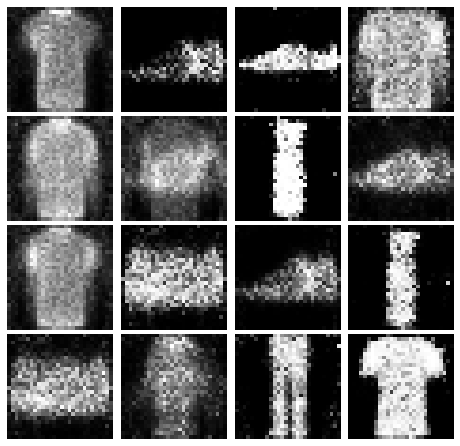

Epoch: 30 / 100 Losses: 
Discriminator: 0.4503 | Generator 3.1193
D(x): 0.9175 | D(G(z)): 0.2123


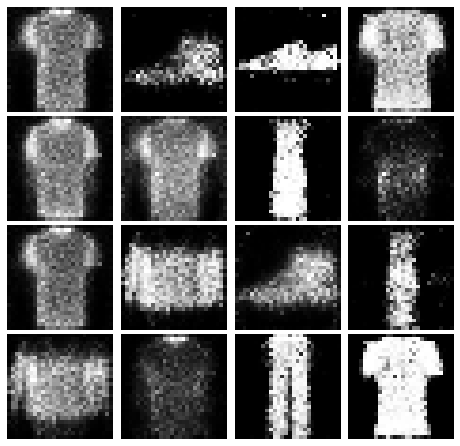

Epoch: 31 / 100 Losses: 
Discriminator: 0.7641 | Generator 2.6010
D(x): 0.7390 | D(G(z)): 0.1543


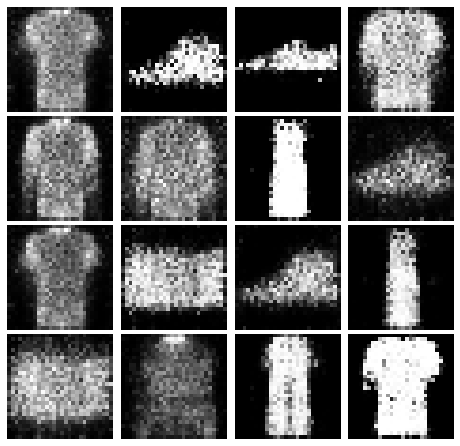

Epoch: 32 / 100 Losses: 
Discriminator: 0.5667 | Generator 3.4211
D(x): 0.8216 | D(G(z)): 0.1139


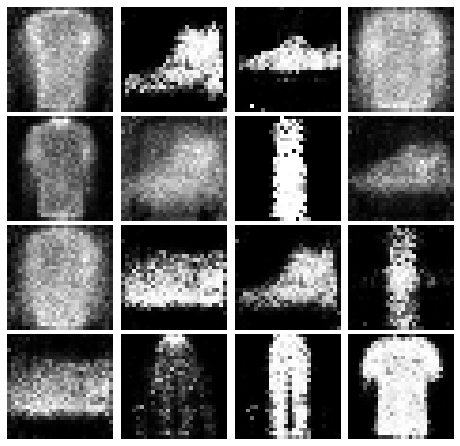

Epoch: 33 / 100 Losses: 
Discriminator: 0.5360 | Generator 3.7060
D(x): 0.8340 | D(G(z)): 0.1005


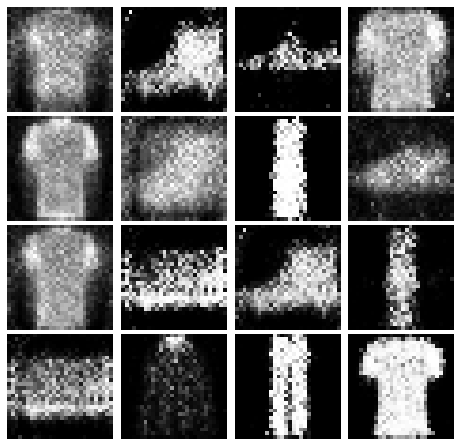

Epoch: 34 / 100 Losses: 
Discriminator: 0.3713 | Generator 3.1724
D(x): 0.8869 | D(G(z)): 0.1566


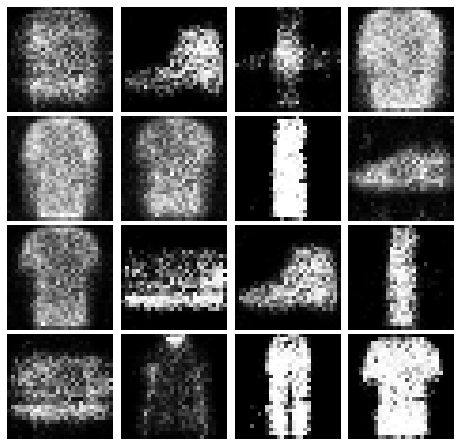

Epoch: 35 / 100 Losses: 
Discriminator: 0.7311 | Generator 3.0915
D(x): 0.7347 | D(G(z)): 0.1287


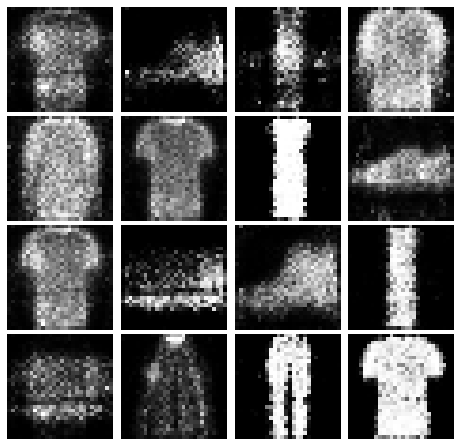

Epoch: 36 / 100 Losses: 
Discriminator: 0.5598 | Generator 2.4873
D(x): 0.8331 | D(G(z)): 0.1957


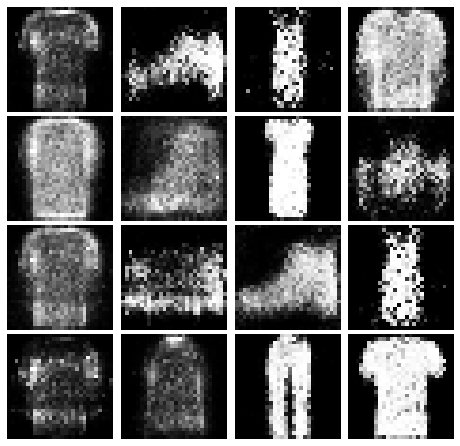

Epoch: 37 / 100 Losses: 
Discriminator: 0.6869 | Generator 4.0059
D(x): 0.7863 | D(G(z)): 0.1316


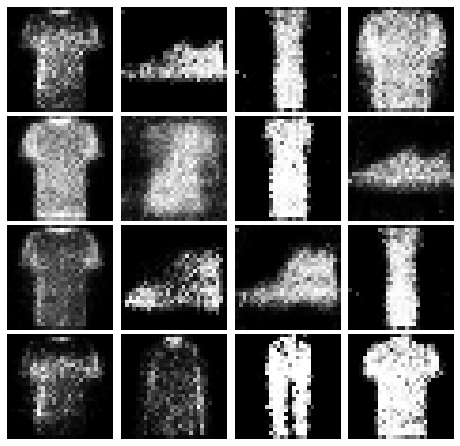

Epoch: 38 / 100 Losses: 
Discriminator: 0.5482 | Generator 3.3743
D(x): 0.7980 | D(G(z)): 0.0951


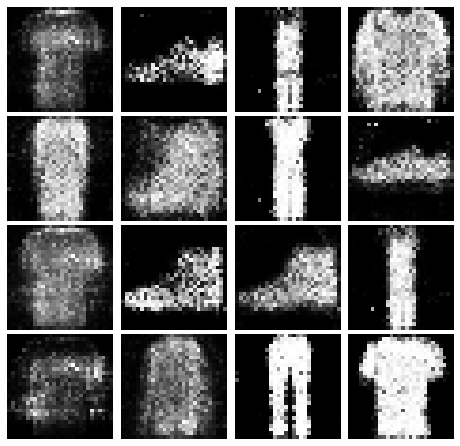

Epoch: 39 / 100 Losses: 
Discriminator: 0.6783 | Generator 3.5144
D(x): 0.7890 | D(G(z)): 0.1471


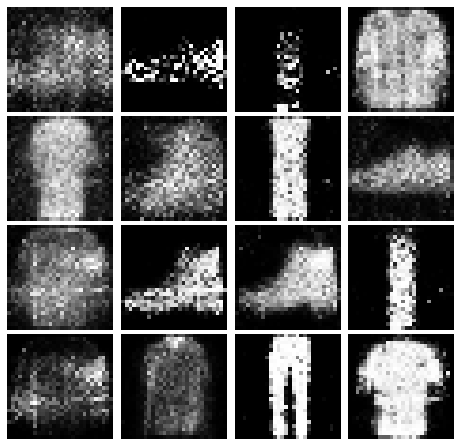

Epoch: 40 / 100 Losses: 
Discriminator: 0.4674 | Generator 2.6799
D(x): 0.8796 | D(G(z)): 0.2027


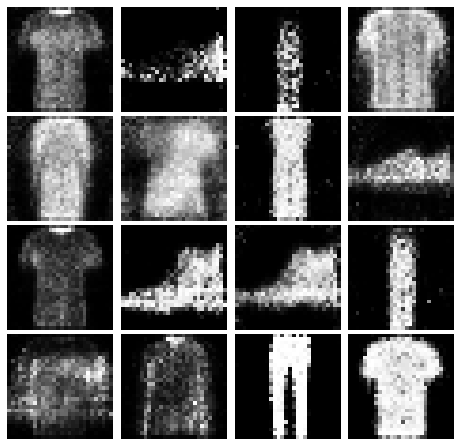

Epoch: 41 / 100 Losses: 
Discriminator: 0.4943 | Generator 2.8616
D(x): 0.8878 | D(G(z)): 0.1746


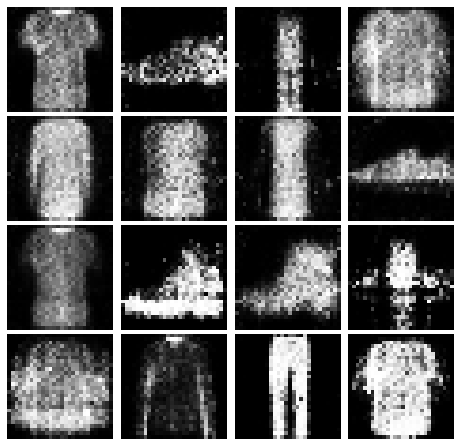

Epoch: 42 / 100 Losses: 
Discriminator: 0.6469 | Generator 2.6018
D(x): 0.7990 | D(G(z)): 0.1586


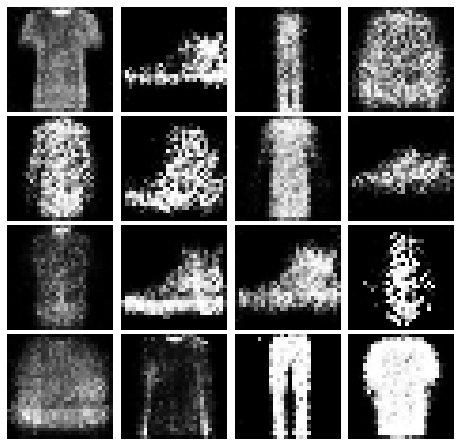

Epoch: 43 / 100 Losses: 
Discriminator: 0.9031 | Generator 3.4367
D(x): 0.7556 | D(G(z)): 0.2670


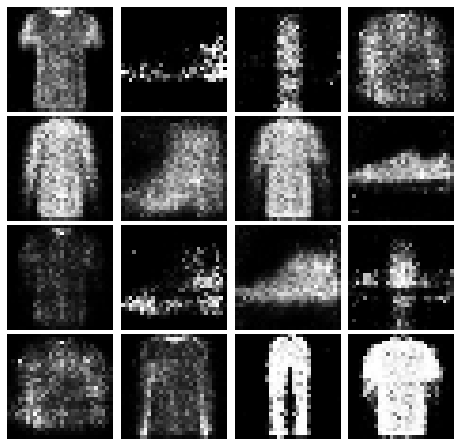

Epoch: 44 / 100 Losses: 
Discriminator: 0.6666 | Generator 2.6850
D(x): 0.8009 | D(G(z)): 0.1835


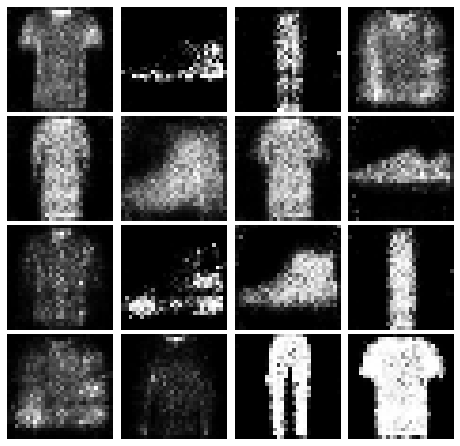

Epoch: 45 / 100 Losses: 
Discriminator: 0.7766 | Generator 2.3788
D(x): 0.8201 | D(G(z)): 0.2821


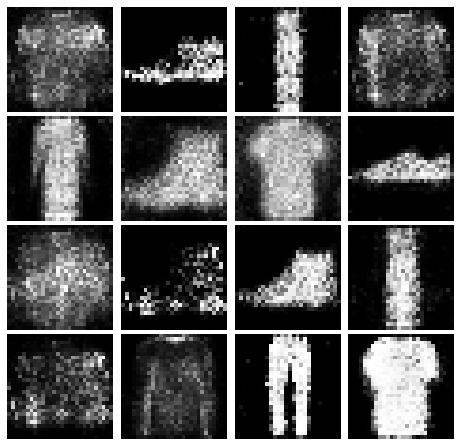

Epoch: 46 / 100 Losses: 
Discriminator: 0.9013 | Generator 3.5687
D(x): 0.8099 | D(G(z)): 0.2574


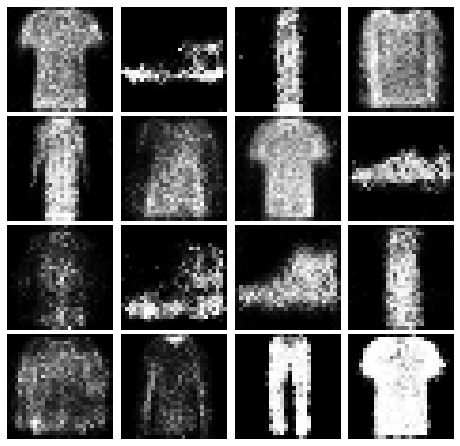

Epoch: 47 / 100 Losses: 
Discriminator: 0.8187 | Generator 1.8540
D(x): 0.7056 | D(G(z)): 0.1957


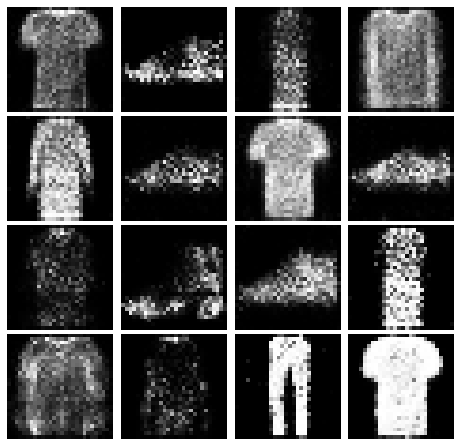

Epoch: 48 / 100 Losses: 
Discriminator: 0.7060 | Generator 2.6144
D(x): 0.7468 | D(G(z)): 0.1700


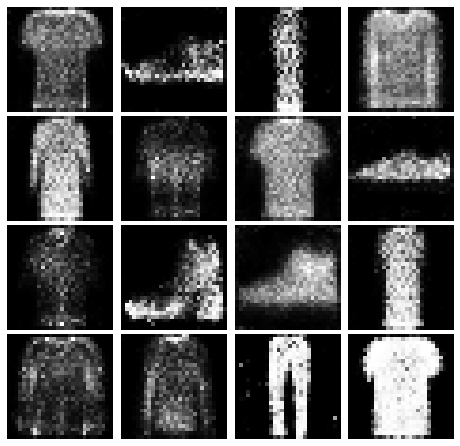

Epoch: 49 / 100 Losses: 
Discriminator: 0.5530 | Generator 2.2977
D(x): 0.7955 | D(G(z)): 0.1439


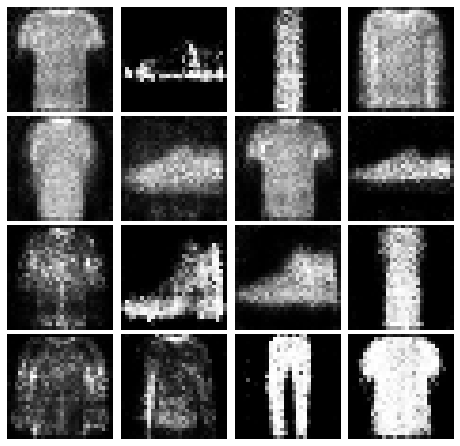

Epoch: 50 / 100 Losses: 
Discriminator: 0.9369 | Generator 4.9118
D(x): 0.8305 | D(G(z)): 0.2857


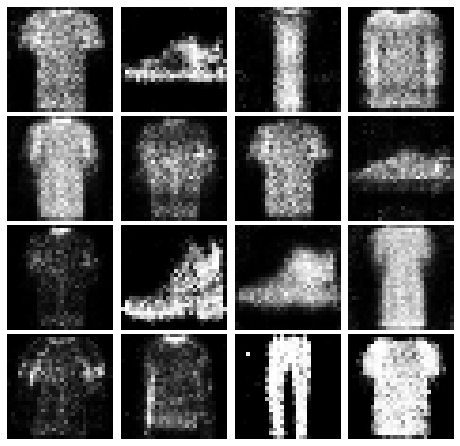

Epoch: 51 / 100 Losses: 
Discriminator: 0.8007 | Generator 2.2167
D(x): 0.7383 | D(G(z)): 0.2394


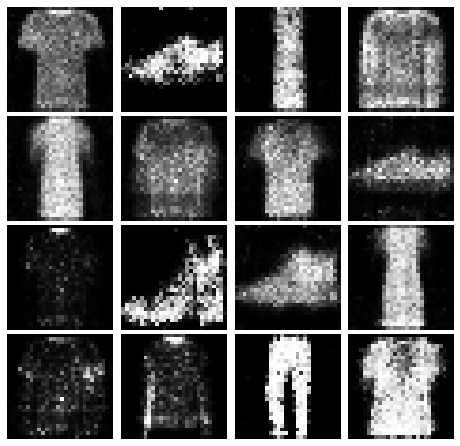

Epoch: 52 / 100 Losses: 
Discriminator: 0.9396 | Generator 1.8529
D(x): 0.8296 | D(G(z)): 0.3875


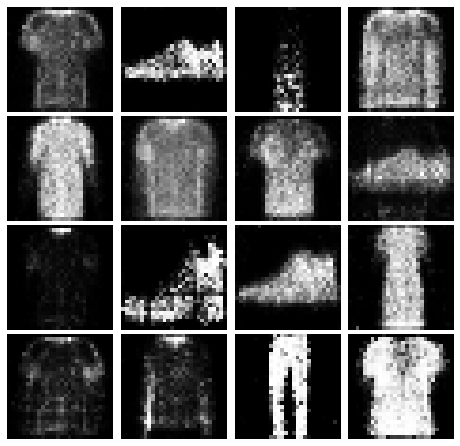

Epoch: 53 / 100 Losses: 
Discriminator: 0.7981 | Generator 1.9863
D(x): 0.7851 | D(G(z)): 0.2791


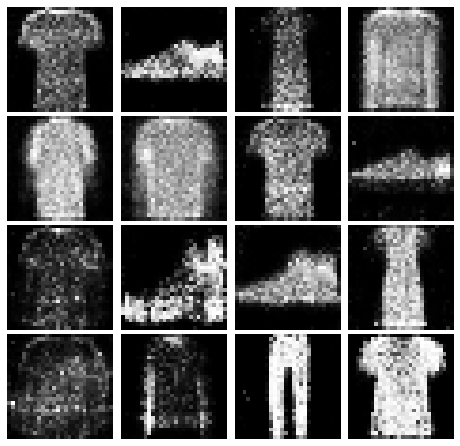

Epoch: 54 / 100 Losses: 
Discriminator: 0.6658 | Generator 2.6133
D(x): 0.7374 | D(G(z)): 0.1719


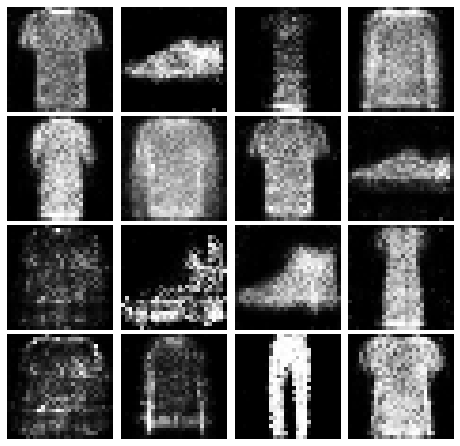

Epoch: 55 / 100 Losses: 
Discriminator: 0.7685 | Generator 2.1565
D(x): 0.7971 | D(G(z)): 0.2665


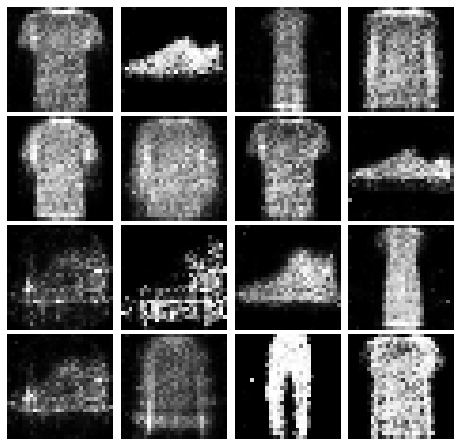

Epoch: 56 / 100 Losses: 
Discriminator: 0.6253 | Generator 1.9398
D(x): 0.7583 | D(G(z)): 0.1580


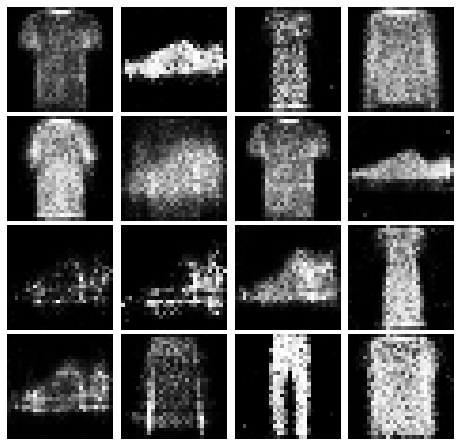

Epoch: 57 / 100 Losses: 
Discriminator: 0.7540 | Generator 1.7757
D(x): 0.7469 | D(G(z)): 0.2680


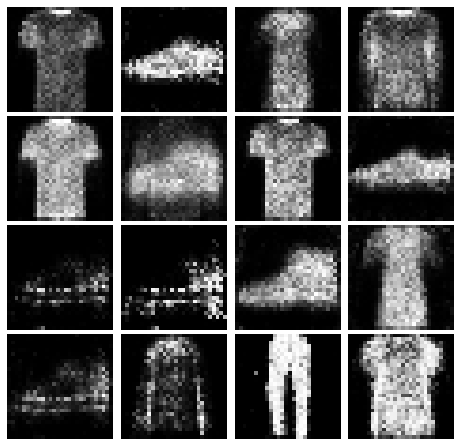

Epoch: 58 / 100 Losses: 
Discriminator: 0.5577 | Generator 1.9438
D(x): 0.7874 | D(G(z)): 0.1950


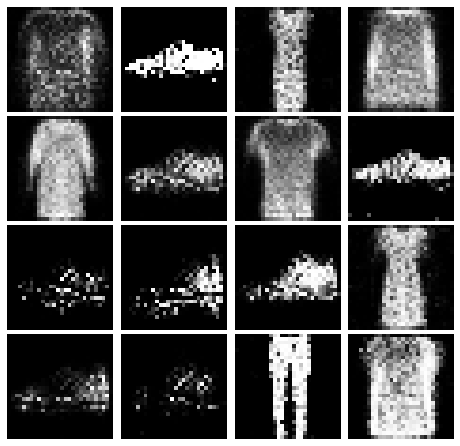

Epoch: 59 / 100 Losses: 
Discriminator: 1.1422 | Generator 2.7811
D(x): 0.7594 | D(G(z)): 0.3436


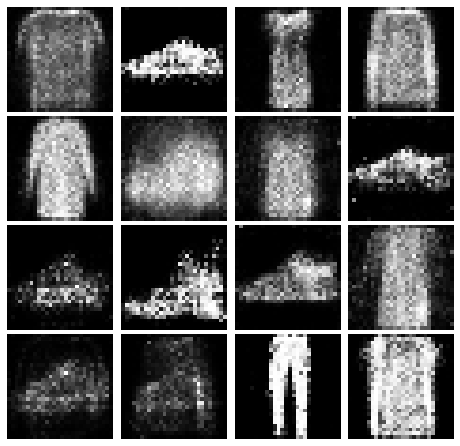

Epoch: 60 / 100 Losses: 
Discriminator: 0.6958 | Generator 1.9275
D(x): 0.7925 | D(G(z)): 0.2570


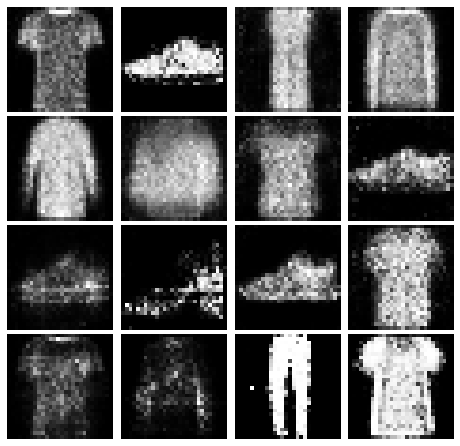

Epoch: 61 / 100 Losses: 
Discriminator: 1.6439 | Generator 3.3445
D(x): 0.7928 | D(G(z)): 0.4765


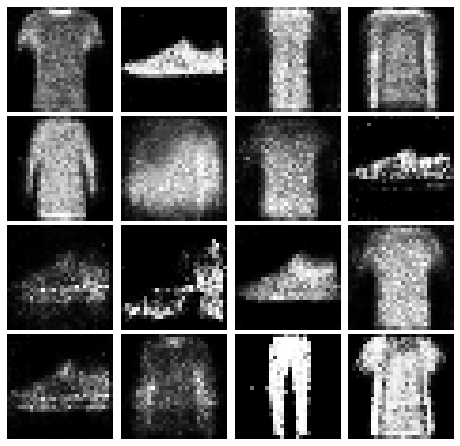

Epoch: 62 / 100 Losses: 
Discriminator: 1.1409 | Generator 2.0062
D(x): 0.6971 | D(G(z)): 0.3173


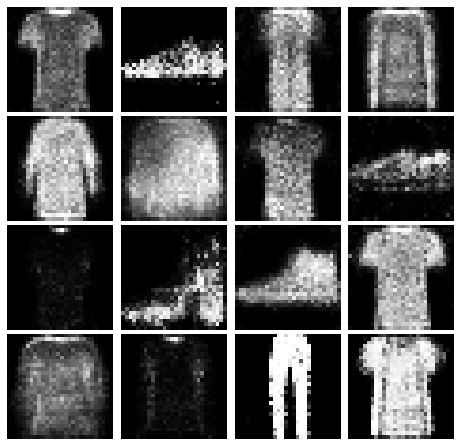

Epoch: 63 / 100 Losses: 
Discriminator: 0.7065 | Generator 1.9651
D(x): 0.7793 | D(G(z)): 0.2586


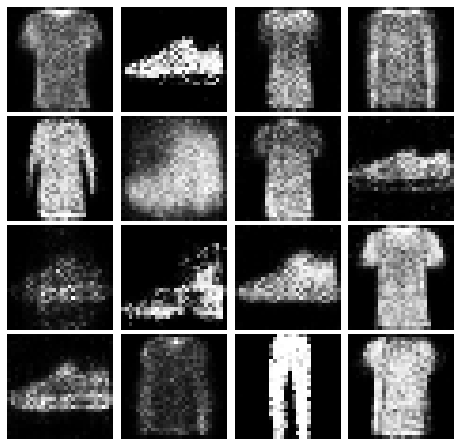

Epoch: 64 / 100 Losses: 
Discriminator: 0.7810 | Generator 2.3845
D(x): 0.7321 | D(G(z)): 0.2125


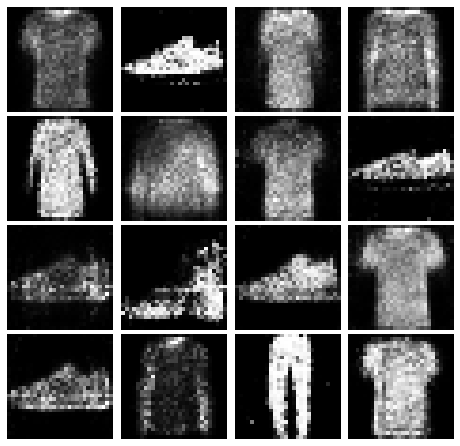

Epoch: 65 / 100 Losses: 
Discriminator: 0.7834 | Generator 2.3674
D(x): 0.8027 | D(G(z)): 0.3036


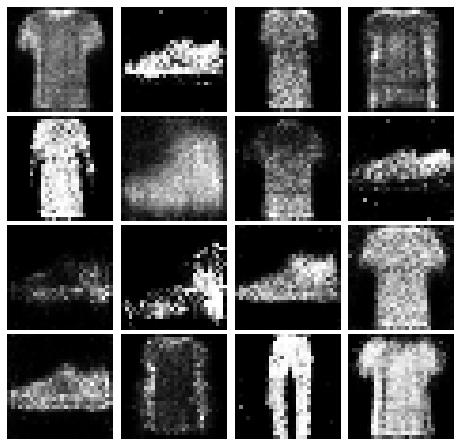

Epoch: 66 / 100 Losses: 
Discriminator: 1.0797 | Generator 1.8317
D(x): 0.7006 | D(G(z)): 0.3522


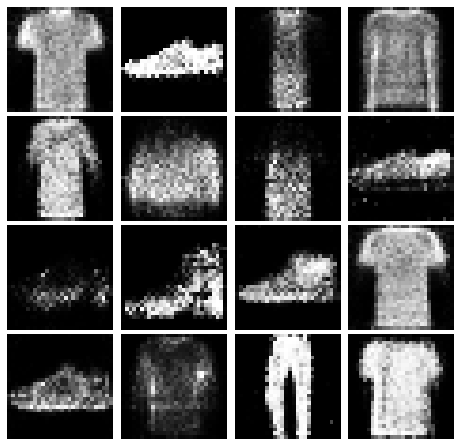

Epoch: 67 / 100 Losses: 
Discriminator: 1.3097 | Generator 2.8428
D(x): 0.5617 | D(G(z)): 0.1531


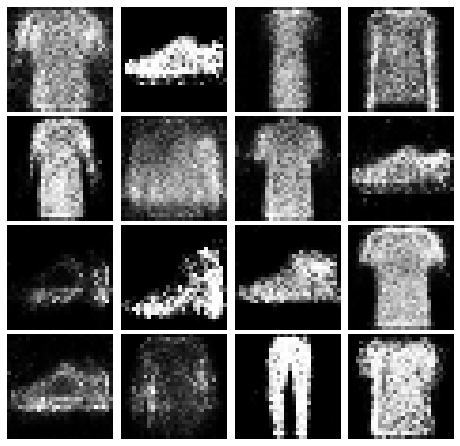

Epoch: 68 / 100 Losses: 
Discriminator: 0.5267 | Generator 2.2914
D(x): 0.8325 | D(G(z)): 0.2076


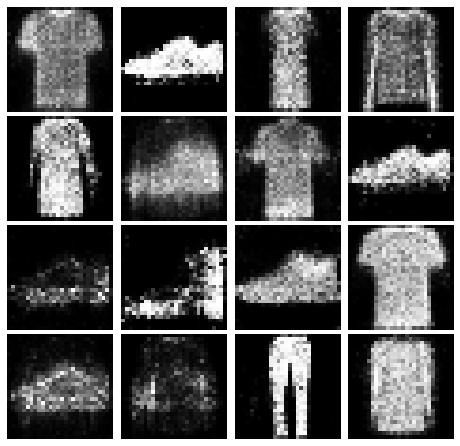

Epoch: 69 / 100 Losses: 
Discriminator: 1.2189 | Generator 1.6621
D(x): 0.6115 | D(G(z)): 0.2823


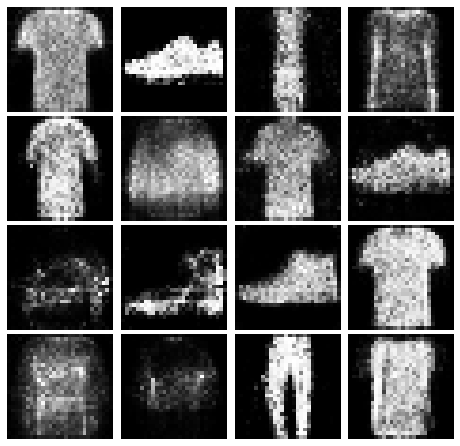

Epoch: 70 / 100 Losses: 
Discriminator: 0.7549 | Generator 2.0815
D(x): 0.7985 | D(G(z)): 0.3024


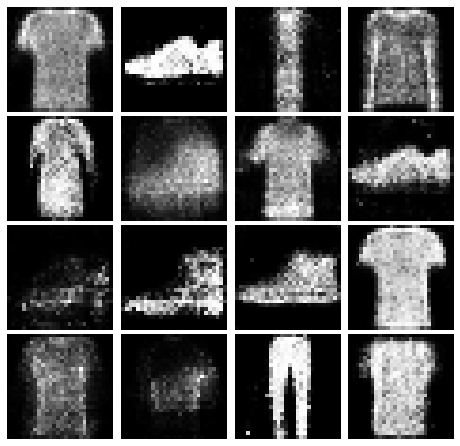

Epoch: 71 / 100 Losses: 
Discriminator: 1.4060 | Generator 1.3313
D(x): 0.5379 | D(G(z)): 0.3799


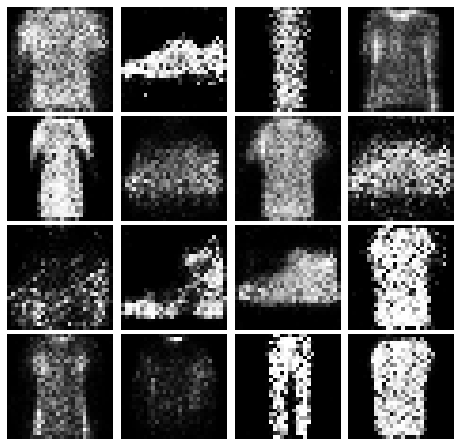

Epoch: 72 / 100 Losses: 
Discriminator: 0.7062 | Generator 2.3071
D(x): 0.7553 | D(G(z)): 0.2346


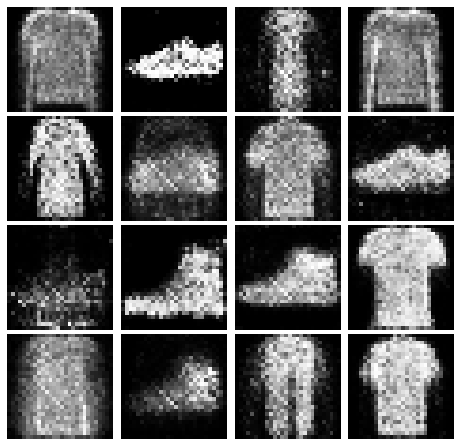

Epoch: 73 / 100 Losses: 
Discriminator: 0.8376 | Generator 2.4525
D(x): 0.7747 | D(G(z)): 0.3194


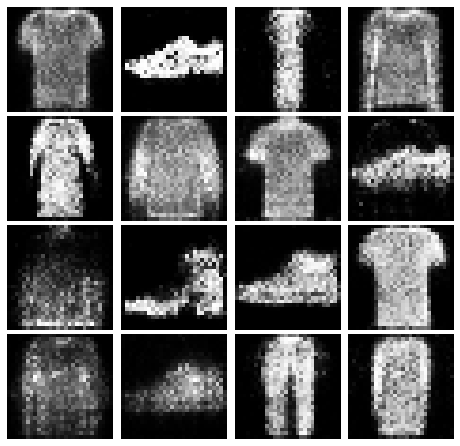

Epoch: 74 / 100 Losses: 
Discriminator: 0.6860 | Generator 2.6726
D(x): 0.8279 | D(G(z)): 0.2913


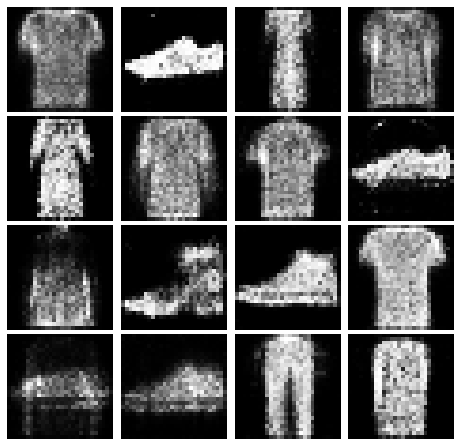

Epoch: 75 / 100 Losses: 
Discriminator: 0.8228 | Generator 1.5998
D(x): 0.7254 | D(G(z)): 0.2837


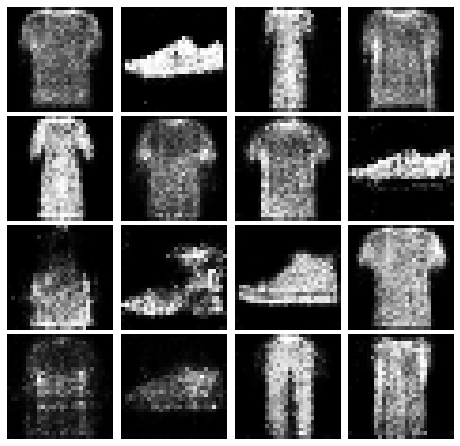

Epoch: 76 / 100 Losses: 
Discriminator: 0.7562 | Generator 1.2021
D(x): 0.7149 | D(G(z)): 0.2138


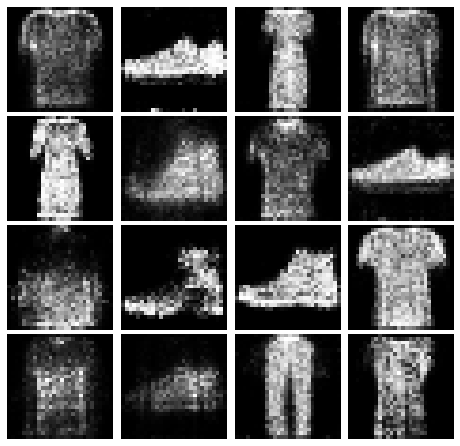

Epoch: 77 / 100 Losses: 
Discriminator: 1.1878 | Generator 1.5383
D(x): 0.6033 | D(G(z)): 0.3016


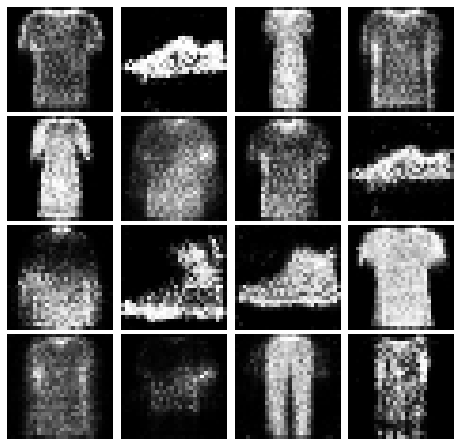

Epoch: 78 / 100 Losses: 
Discriminator: 0.9145 | Generator 1.3830
D(x): 0.7694 | D(G(z)): 0.3151


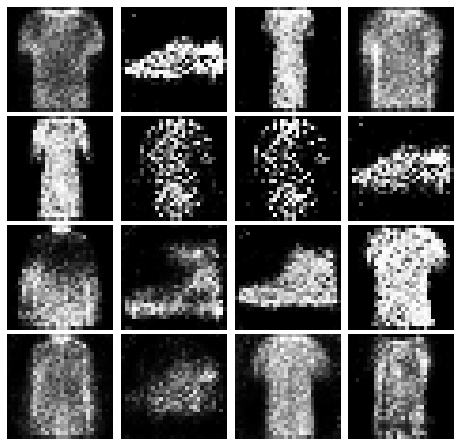

Epoch: 79 / 100 Losses: 
Discriminator: 0.7213 | Generator 1.9771
D(x): 0.7686 | D(G(z)): 0.2748


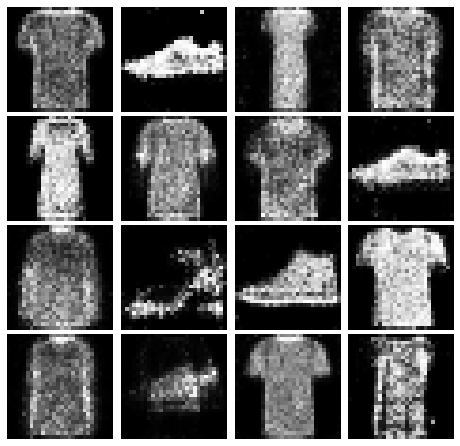

Epoch: 80 / 100 Losses: 
Discriminator: 0.8938 | Generator 2.2175
D(x): 0.6232 | D(G(z)): 0.1882


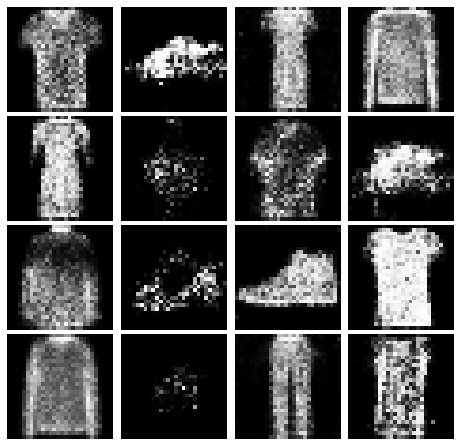

Epoch: 81 / 100 Losses: 
Discriminator: 0.9771 | Generator 2.3960
D(x): 0.8089 | D(G(z)): 0.3366


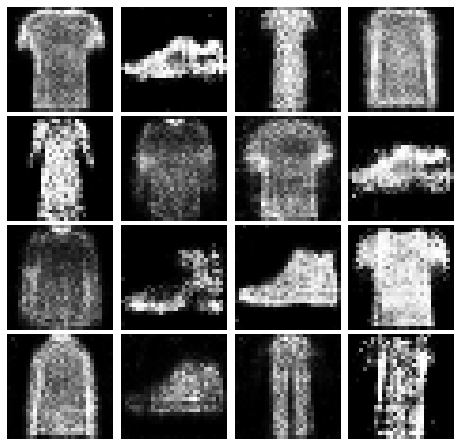

Epoch: 82 / 100 Losses: 
Discriminator: 0.9573 | Generator 1.8720
D(x): 0.6826 | D(G(z)): 0.2079


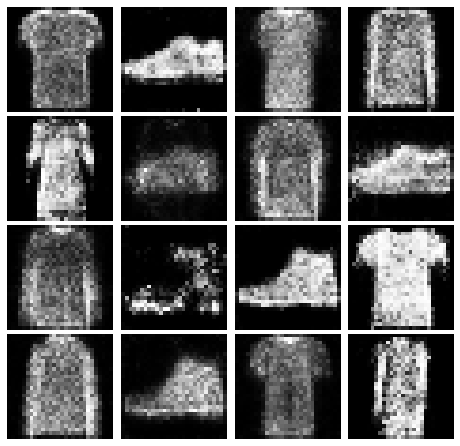

Epoch: 83 / 100 Losses: 
Discriminator: 0.9248 | Generator 1.8208
D(x): 0.6869 | D(G(z)): 0.2628


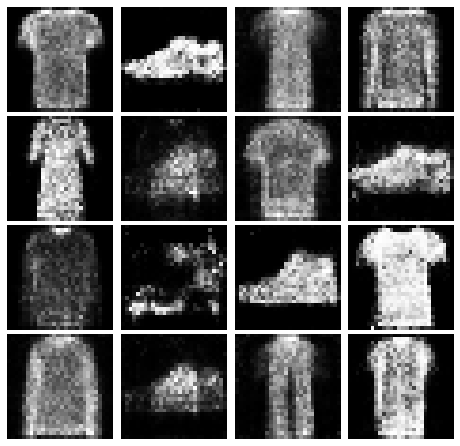

Epoch: 84 / 100 Losses: 
Discriminator: 0.7900 | Generator 2.2038
D(x): 0.7607 | D(G(z)): 0.2408


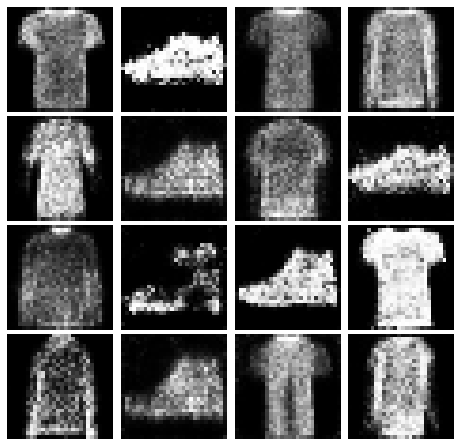

Epoch: 85 / 100 Losses: 
Discriminator: 0.9408 | Generator 1.8801
D(x): 0.7047 | D(G(z)): 0.3003


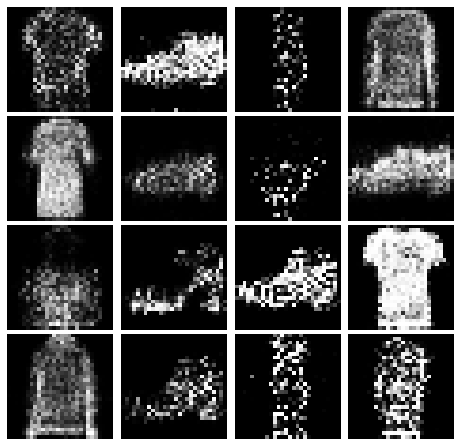

Epoch: 86 / 100 Losses: 
Discriminator: 0.6091 | Generator 2.9717
D(x): 0.8678 | D(G(z)): 0.2745


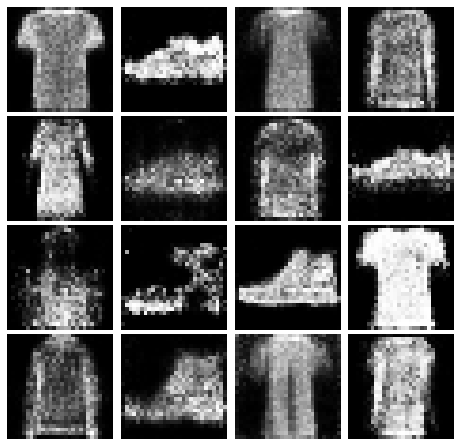

Epoch: 87 / 100 Losses: 
Discriminator: 0.8258 | Generator 1.9654
D(x): 0.7469 | D(G(z)): 0.2708


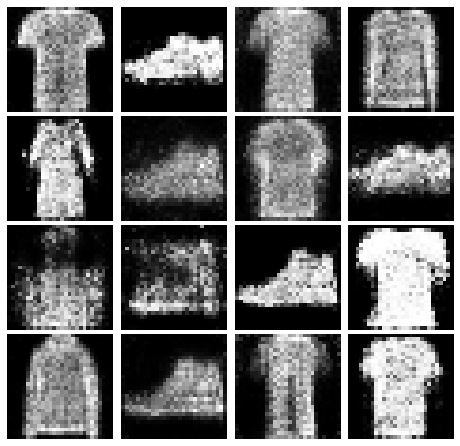

Epoch: 88 / 100 Losses: 
Discriminator: 1.0069 | Generator 1.5229
D(x): 0.6852 | D(G(z)): 0.3776


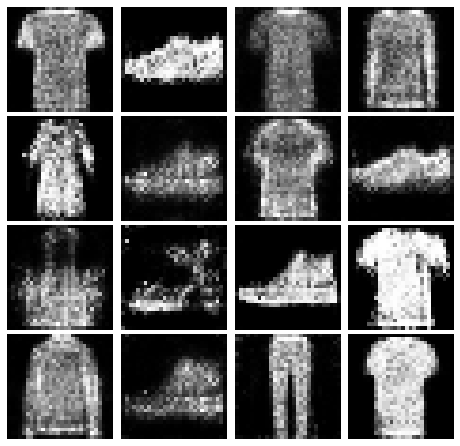

Epoch: 89 / 100 Losses: 
Discriminator: 0.7317 | Generator 1.3869
D(x): 0.7636 | D(G(z)): 0.2553


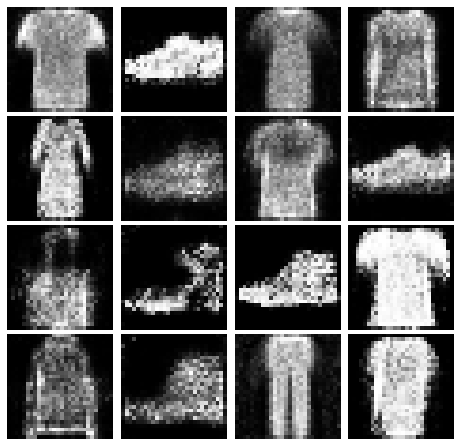

Epoch: 90 / 100 Losses: 
Discriminator: 0.8343 | Generator 1.3703
D(x): 0.7737 | D(G(z)): 0.3382


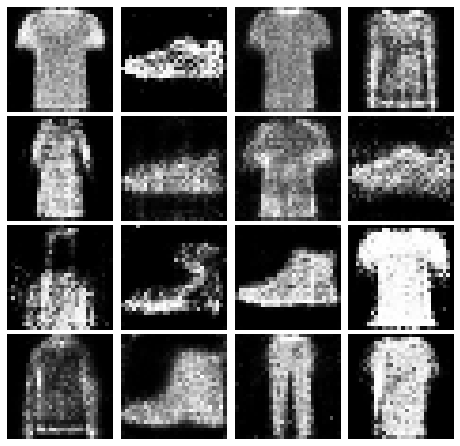

Epoch: 91 / 100 Losses: 
Discriminator: 0.8900 | Generator 1.8613
D(x): 0.7938 | D(G(z)): 0.3487


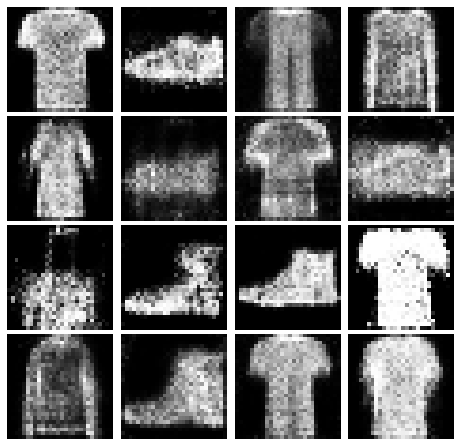

Epoch: 92 / 100 Losses: 
Discriminator: 0.7278 | Generator 2.1472
D(x): 0.7372 | D(G(z)): 0.2144


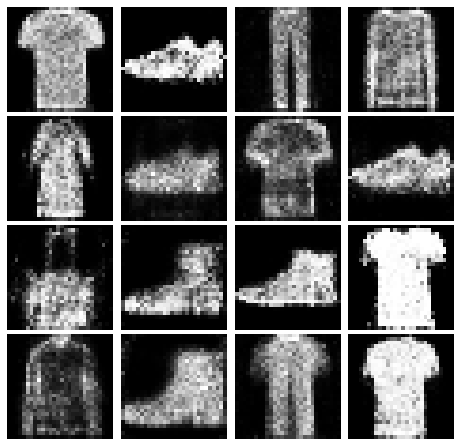

Epoch: 93 / 100 Losses: 
Discriminator: 1.0726 | Generator 1.4084
D(x): 0.6944 | D(G(z)): 0.3694


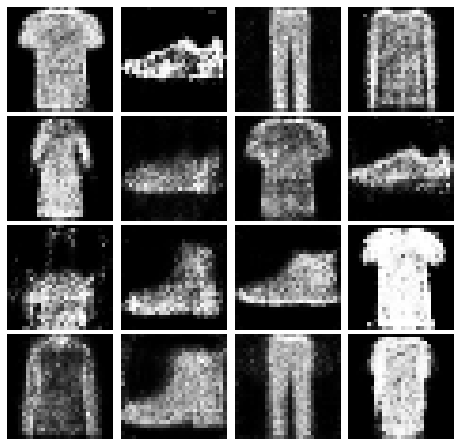

Epoch: 94 / 100 Losses: 
Discriminator: 0.9319 | Generator 1.4503
D(x): 0.7320 | D(G(z)): 0.3438


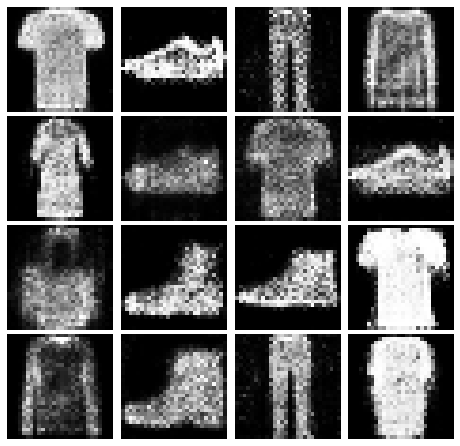

Epoch: 95 / 100 Losses: 
Discriminator: 1.3514 | Generator 2.6043
D(x): 0.6241 | D(G(z)): 0.2900


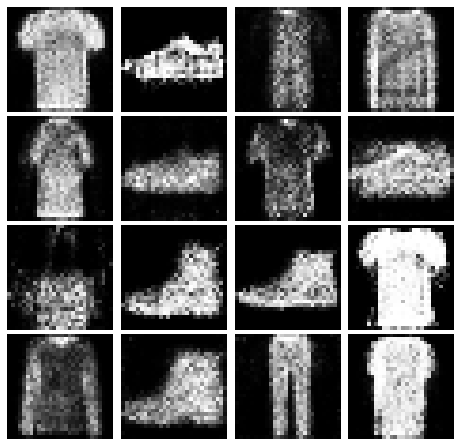

Epoch: 96 / 100 Losses: 
Discriminator: 0.6247 | Generator 1.9376
D(x): 0.7746 | D(G(z)): 0.2339


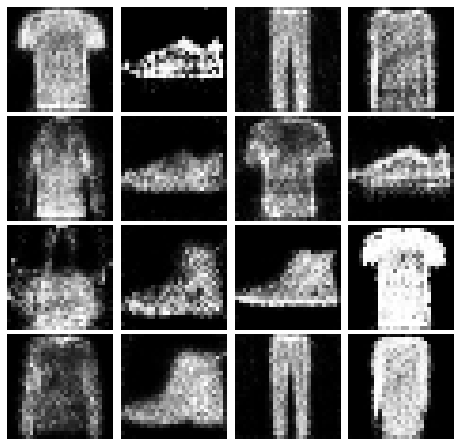

Epoch: 97 / 100 Losses: 
Discriminator: 0.6126 | Generator 2.1417
D(x): 0.8045 | D(G(z)): 0.2462


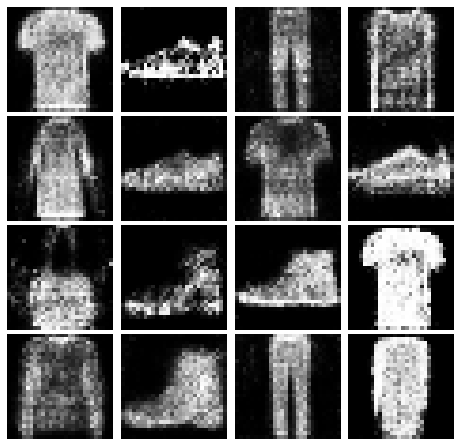

Epoch: 98 / 100 Losses: 
Discriminator: 1.1324 | Generator 1.2679
D(x): 0.6276 | D(G(z)): 0.3924


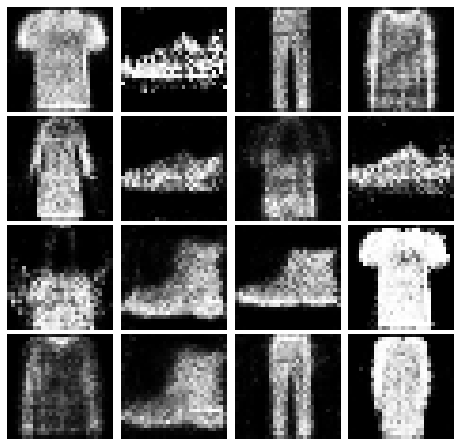

Epoch: 99 / 100 Losses: 
Discriminator: 1.0609 | Generator 2.4343
D(x): 0.6155 | D(G(z)): 0.1990


In [20]:
# instanciando o número de épocas para o treino
num_epochs = 100

# lista para salvar os erros do gerador e do discriminador
G_losses = []
D_losses = []

for epoch in range(num_epochs):
    for realbatch, _ in dataloader:

        real_data = images_to_vectors(realbatch).to(device)

        fake_data = generator(
            noise(real_data.size(0)))

        d_error, dpred_real, dpred_fake = (
            train_discriminator(d_optimizer, 
                                real_data, 
                                fake_data))
        
        fake_data = generator(noise(realbatch.size(0)))
        
        g_error = train_generator(g_optimizer, 
                                  fake_data)
        
    imagepath = os.path.join(IMG_DIR, 
                             f'{epoch + 1}.jpg')
    
    test_images = vectors_to_images(
        generator(test_noise)).cpu().detach().numpy()

    log_images(test_images, imagepath)

    G_losses.append(g_error)
    D_losses.append(d_error)

    print(f'Epoch: {epoch} / {num_epochs} Losses: ')
    print(f'Discriminator: {d_error:.4f} | Generator {g_error:.4f}')
    print(f'D(x): {dpred_real.mean():.4f} | D(G(z)): {dpred_fake.mean():.4f}')

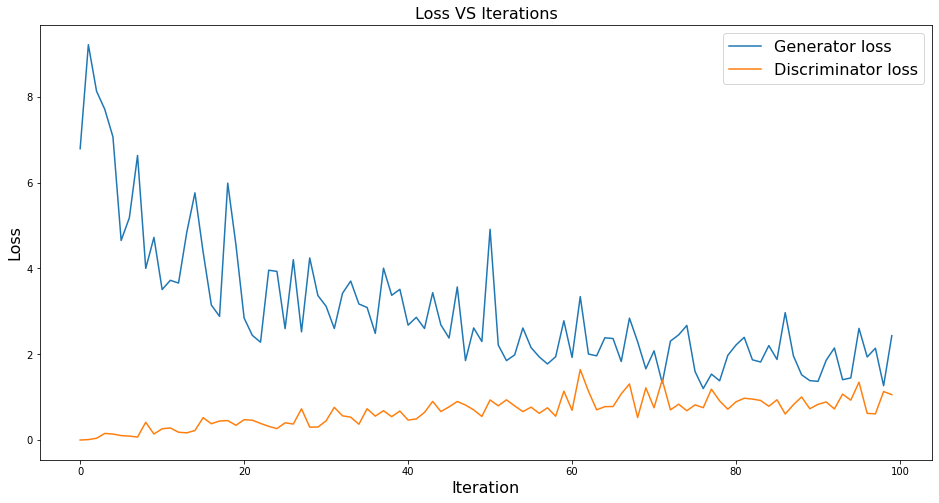

In [21]:
# função para visualizar os erros do gerador e do discriminador
def plot_losses(losses):
    fig = plt.figure(figsize=[16, 8])
    ax = fig.gca()

    for loss_name, loss_values in losses.items():
        loss_values = [k.item() for k in loss_values]
        ax.plot(loss_values, label=loss_name)

    ax.legend(fontsize='16')
    ax.set_xlabel('Iteration', fontsize='16')
    ax.set_ylabel('Loss', fontsize='16')
    ax.set_title('Loss VS Iterations', fontsize='16')

plot_losses({
    'Generator loss': G_losses, 
    'Discriminator loss': D_losses
});

In [22]:
# importando a biblioteca para gerar gif
import imageio

In [23]:
# lista para salvar o gif
images = []

# realizando um laço de repetição 
for filename in sorted(os.listdir(IMG_DIR), key = lambda x: float(x.split('.')[0])):
    if filename.endswith('.jpg'):
        filepath = os.path.join(IMG_DIR, filename)
        images.append(imageio.imread(filepath))

imageio.mimsave('fashion_training.gif', images)